In [44]:
import matplotlib.pyplot as plt
import numpy as np
from HelperAndMechanics import *
from matplotlib import cm

# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

import jax.numpy as jnp
from jax import jit
from jax.scipy.signal import convolve2d
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
from jax import tree_util

import numpy as np
import os
import matplotlib.pyplot as plt

from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE

In [ ]:
# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta_05_uv.h5', 'r') as f:
    dA = f['dA'][:]
    u = f['u'][:]
    T = f['T'][:]
    v = f['v'][:]
    f.close()
N = T.shape[0]


In [31]:
@jit
def distance_y(xy_grid):
    return (xy_grid[:,1:] - xy_grid[:,:-1])
@jit
def distance_x(xy_grid):
    return (xy_grid[:,:, 1:] - xy_grid[:,:, :-1])
@jit 
def distance_axial(xy_cm_grid,axial_grid):
    return (xy_cm_grid - axial_grid)     
@jit
def zero_out_edges(force):
        force = force.at[:,0, :].set(0)   # Top row
        force = force.at[:,-1, :].set(0)  # Bottom row
        force = force.at[:,:, 0].set(0)   # Left column
        force = force.at[:,:, -1].set(0)  # Right column
        return force
@jit
def force_field_struct(xy_grid,par):
    '''calculates the structural forces on the grid; enforces zero force on the edges
    input: shape (2, n, m) array of xy coordinates
    output: shape (2, n, m) array of forces'''

    #y-direction -> 
    #x-direction ^
    
    # x -- x -- x    
    # |    |    |
    # x -- x -- x    
    # |    |    |
    # x -- x -- x    
    l_g = jnp.full(xy_grid.shape, par['l_g'])
    k_struct = jnp.full(xy_grid.shape, par['k_struct'])

    d_y = distance_y(xy_grid)#points to the top
    d_x = distance_x(xy_grid)#points to the right

    # Apply padding on vertical distances
    d_y_upward = jnp.pad(d_y, ((0, 0), (1, 0), (0, 0)))  
    d_y_downward = jnp.pad(d_y, ((0, 0), (0, 1), (0, 0)))  

    # Apply padding on horizontal distances
    d_x_right = jnp.pad(d_x, ((0, 0), (0, 0), (1, 0))) 
    d_x_left= jnp.pad(d_x, ((0, 0), (0, 0), (0, 1)))  
    # print(np.linalg.norm(d_y_upward,axis = 0).shape)

    y_force_upward = k_struct*(l_g-jnp.linalg.norm(d_y_upward,axis = 0)) * d_y_upward/jnp.linalg.norm(d_y_upward,axis = 0) #force points to -y-direction
    y_force_downward = -k_struct*(l_g-jnp.linalg.norm(d_y_downward,axis = 0)) * d_y_downward/jnp.linalg.norm(d_y_downward,axis = 0) #force points to +y-direction
    x_force_left = -k_struct*(l_g-jnp.linalg.norm(d_x_left,axis = 0)) * d_x_left/jnp.linalg.norm(d_x_left,axis = 0) #force points to -x-direction
    x_force_right = k_struct*(l_g-jnp.linalg.norm(d_x_right,axis = 0)) * d_x_right/jnp.linalg.norm(d_x_right,axis = 0) #force points to +x-direction
    # print(d_y_upward/jnp.linalg.norm(d_y_upward,axis = 0))
    return zero_out_edges(y_force_upward+ y_force_downward+ x_force_left+ x_force_right)
@jit
def force_field_active(xy_grid,T,par):
    '''calculates the active forces on the grid; enforces zero force on the edges
    input: xy grid shape (2, size+2pad+1, size+2pad+1) array of xy coordinates
        T shape (size, size) array of electric signal
        enforces two lazers of same T outside the simulatio grid and pads the rest of the T values with 0
    output: shape (2, size+2pad+1, size+2pad+1) array of forces
        enforces zero force on the edges'''
    attachment_right, attachment_left = interpolate_active(xy_grid, par['n'])
    x_cm = center_of_mass_neighbors(xy_grid)
    
    #all distances point to the center of mass points
    d_act_right_to_bottom = distance_axial(x_cm, attachment_right)
    d_act_right_to_bottom = jnp.pad(d_act_right_to_bottom, ((0, 0), (0, 1), (1, 0)))
    d_act_right_to_top = distance_axial(x_cm, attachment_right)
    d_act_right_to_top = jnp.pad(d_act_right_to_top, ((0, 0), (1, 0), (1, 0)))  
    d_act_left_to_bottom = distance_axial(x_cm, attachment_left)
    d_act_left_to_bottom = jnp.pad(d_act_left_to_bottom, ((0, 0), (0, 1), (0, 1)))
    d_act_left_to_top = distance_axial(x_cm, attachment_left)
    d_act_left_to_top = jnp.pad(d_act_left_to_top, ((0, 0), (1, 0), (0, 1)))
    # pad electric signal 
    T_padded = enforce_T_and_pad(T, xy_grid)#shape (size+2pad, size+2pad)
    # initiate params
    k_active = jnp.full(xy_grid.shape, par['k_active'])
    l_a = jnp.full(T_padded.shape, par['l_a'])
    n = par['n']
    l_a_effective = l_a / (1+par['c_a']*T_padded)#shape (size+2pad, size+2pad)
    # Compute the spring forces acting on the grid; division by zero on the edges gets nan --> zero out edges in the end
    force_right_to_bottom = -(1-n) * k_active*(jnp.pad(l_a_effective,((0, 0), (0, 1), (1, 0)))-jnp.linalg.norm(d_act_right_to_bottom,axis = 0)) * d_act_right_to_bottom/jnp.linalg.norm(d_act_right_to_bottom,axis = 0) 
    force_right_to_top = -n * k_active*(jnp.pad(l_a_effective,((0, 0), (1, 0), (1, 0))) -jnp.linalg.norm(d_act_right_to_top,axis = 0)) * d_act_right_to_top/jnp.linalg.norm(d_act_right_to_top,axis = 0) 
    force_left_to_bottom = -n * k_active*(jnp.pad(l_a_effective,((0, 0), (0, 1), (0, 1)))-jnp.linalg.norm(d_act_left_to_bottom,axis = 0)) * d_act_left_to_bottom/jnp.linalg.norm(d_act_left_to_bottom,axis = 0)       
    force_left_to_top = -(1-n) * k_active*(jnp.pad(l_a_effective, ((0, 0), (1, 0), (0, 1)))-jnp.linalg.norm(d_act_left_to_top,axis = 0)) * d_act_left_to_top/jnp.linalg.norm(d_act_left_to_top,axis = 0) 
    
    return zero_out_edges(force_right_to_bottom+force_right_to_top+force_left_to_bottom+force_left_to_top)
@jit
def force_field_passive(xy_grid,par):
    '''calculates the passive forces on the grid; enforces zero force on the edges
    input: shape (2, size+2pad, size+2pad) array of xy coordinates
    output: shape (2, size+2pad, size+2pad) array of forces
        enforces zero force on the edges'''
    attachment_top, attachment_bottom = interpolate_passive(xy_grid, par['n'])
    x_cm = center_of_mass_neighbors(xy_grid)
    d_pass_top_to_right = distance_axial(x_cm,attachment_top)
    d_pass_top_to_right = jnp.pad(d_pass_top_to_right, ((0, 0), (1, 0), (1, 0)))
    d_pass_top_to_left = distance_axial(x_cm,attachment_top)
    d_pass_top_to_left = jnp.pad(d_pass_top_to_left, ((0, 0), (1, 0), (0, 1)))
    d_pass_bottom_to_right = distance_axial(x_cm,attachment_bottom)
    d_pass_bottom_to_right = jnp.pad(d_pass_bottom_to_right, ((0, 0), (0, 1), (1, 0)))
    d_pass_bottom_to_left = distance_axial(x_cm,attachment_bottom)
    d_pass_bottom_to_left = jnp.pad(d_pass_bottom_to_left, ((0, 0), (0, 1), (0, 1)))
    # initiate params
    k_passive = jnp.full(xy_grid.shape, par['k_passive'])
    l_p = jnp.full(xy_grid.shape, par['l_p'])
    n = par['n']
    
    # Compute the spring forces acting on the grid; division by zero on the edges gets nan --> zero out edges in the end
    force_top_to_right = -n * k_passive*(l_p-jnp.linalg.norm(d_pass_top_to_right,axis = 0)) * d_pass_top_to_right/jnp.linalg.norm(d_pass_top_to_right,axis = 0) 
    force_top_to_left = -(1-n) * k_passive*(l_p-jnp.linalg.norm(d_pass_top_to_left,axis = 0)) * d_pass_top_to_left/jnp.linalg.norm(d_pass_top_to_left,axis = 0)
    force_bottom_to_right = -(1-n) * k_passive*(l_p-jnp.linalg.norm(d_pass_bottom_to_right,axis = 0)) * d_pass_bottom_to_right/jnp.linalg.norm(d_pass_bottom_to_right,axis = 0)
    force_bottom_to_left = -n * k_passive*(l_p-jnp.linalg.norm(d_pass_bottom_to_left,axis = 0)) * d_pass_bottom_to_left/jnp.linalg.norm(d_pass_bottom_to_left,axis = 0)
    
    return zero_out_edges(force_top_to_right+force_top_to_left+force_bottom_to_right+force_bottom_to_left)
@jit
def center_of_mass_neighbors(xy_grid):
    '''calculates the center of mass for each block of 4 neighbors 
    input: shape (2, n, m) array of xy coordinates
    output: shape (2, n-1, m-1) array of xy coordinates'''
    x_coords = xy_grid[0, :, :]
    y_coords = xy_grid[1, :, :]
    
    # Calculate the center of mass for each block of 4 neighbors
    x_com = (x_coords[:-1, :-1] + x_coords[1:, :-1] + x_coords[:-1, 1:] + x_coords[1:, 1:]) / 4
    y_com = (y_coords[:-1, :-1] + y_coords[1:, :-1] + y_coords[:-1, 1:] + y_coords[1:, 1:]) / 4
    
    return jnp.stack([x_com, y_com], axis=0)
@jit
def interpolate_active(xy_grid, n):
    '''interpolates the active spring positions on the right and left walls
    input: shape (2, n, m) array of xy coordinates
    output: 2 arrays of shape (2, n-1, m-1) array of xy coordinates'''
    # Calculate vertical distance between neighboring points in the z-direction
    d_y = distance_y(xy_grid)

    # Compute the attachment point on the right wall using fraction n
    attachment_right = xy_grid[:, :-1, 1:] + n * d_y[:,:,1:]

    # Compute the attachment point on the left wall using fraction (1-n)
    attachment_left = xy_grid[:, :-1, :-1] + (1 - n) * d_y[:, :,:-1]

    # Return the x and z attachment points on the right and left walls respectively
    return attachment_right[:, :, :], attachment_left[:, :, :]
@jit
def interpolate_passive(xy_grid, n):
    '''Interpolates the active spring positions on the top and bottom walls.
    Input: shape (2, n, m) array of xy coordinates
    Output: 2 arrays of shape (2, n-1, m-1) array of xy coordinates'''
    
    d_x = distance_x(xy_grid)  # Compute horizontal distances

    # Top wall interpolation (fraction `n`)
    attachment_top = xy_grid[:, 1:, :-1] + (1 - n) * d_x[:, 1:, :]

    # Bottom wall interpolation (fraction `1 - n`)
    attachment_bottom = xy_grid[:, :-1, :-1] + n * d_x[:, :-1, :]

    return attachment_top, attachment_bottom
@jit
def enforce_T_and_pad(T, xy_grid):
    """Expands T by enforcing single-layer boundary values on left/right & top/bottom, then pads equally.
    
    Args:
        T: jnp.array of shape (size, size) (original simulation grid)
        xy_grid: Coordinates grid  of shape (2, size+2*pad+1, size+2*pad+1)
        pad: Total zero padding (added equally on all sides)
    
    Returns:
        jnp.array of shape (size + 2*pad, size + 2*pad)
    """
    # Enforce left and right boundaries using ONLY the first and last column (not two)
    left_extension = jnp.concatenate([T[:, :1], T[:, :1]], axis=1)  # First column only
    right_extension = jnp.concatenate([T[:, -1:], T[:, -1:]], axis=1)  # Last column only
    T_extended_lr = jnp.concatenate([left_extension, T, right_extension], axis=1)  # Shape: (size, size+2)

    # Enforce top and bottom boundaries using ONLY the first and last row (not two)
    top_extension = jnp.concatenate([T_extended_lr[:1, :], T_extended_lr[:1, :]], axis=0)  # First row only
    bottom_extension = jnp.concatenate([T_extended_lr[-1:, :], T_extended_lr[-1:, :]], axis=0)  # Last row only
    T_extended_tb = jnp.concatenate([top_extension, T_extended_lr, bottom_extension], axis=0)  # Shape: (size+2, size+2)

    # Calculate the padding based on the difference between T size and xy_grid size
    # Assuming that xy_grid size should match the size of T, the padding calculation becomes simpler
    pad = int((xy_grid.shape[1]-T_extended_tb.shape[0]) / 2 )  # Pad the extended grid equally on all sides
    # Pad the extended grid equally on all sides
    T_padded = jnp.pad(T_extended_tb, ((pad, pad), (pad, pad)), mode="constant", constant_values=0)
    return jnp.reshape(T_padded, (1,T_padded.shape[0], T_padded.shape[1]))

In [ ]:
# Create a 100x100 grid of x and z coordinates
size = 100
pad = 10
size_mech = size + 2*pad +1
x_vals = np.linspace(0, size_mech-1,size_mech)
z_vals = np.linspace(0, size_mech-1,size_mech)
# Generate meshgrid for x and z
x_grid, z_grid = np.meshgrid(x_vals, z_vals)
xy_grid = jnp.array([x_grid, z_grid])
T_vals = np.linspace(0, .9, size)


# x_grid[2,2]= x_grid[2,2]+.5

T_grid= np.meshgrid(T_vals, T_vals)[0]
print(T_grid)

# xy_grid = xy_grid.at[0, 2, 2].set(xy_grid[0, 2, 2]+.4)
# Parameters (spring constant and rest length)
par = {
    'k_active': 2.0,  # Example spring constant
    'l_a': .5,  # Example rest length (active)
    'k_passive': 2.0,  # Example spring constant
    'l_p': .5,  # Example rest length (passive)
    'n': 0.5,  # Fraction of active spring force
    'c_a': 1.0,  # Example constant
    'k_struct': 2.0,  # Example spring constant
    'l_g':1  # Example rest length (constant)
    }

[[0.         0.00909091 0.01818182 ... 0.88181818 0.89090909 0.9       ]
 [0.         0.00909091 0.01818182 ... 0.88181818 0.89090909 0.9       ]
 [0.         0.00909091 0.01818182 ... 0.88181818 0.89090909 0.9       ]
 ...
 [0.         0.00909091 0.01818182 ... 0.88181818 0.89090909 0.9       ]
 [0.         0.00909091 0.01818182 ... 0.88181818 0.89090909 0.9       ]
 [0.         0.00909091 0.01818182 ... 0.88181818 0.89090909 0.9       ]]


## Test Mechanics

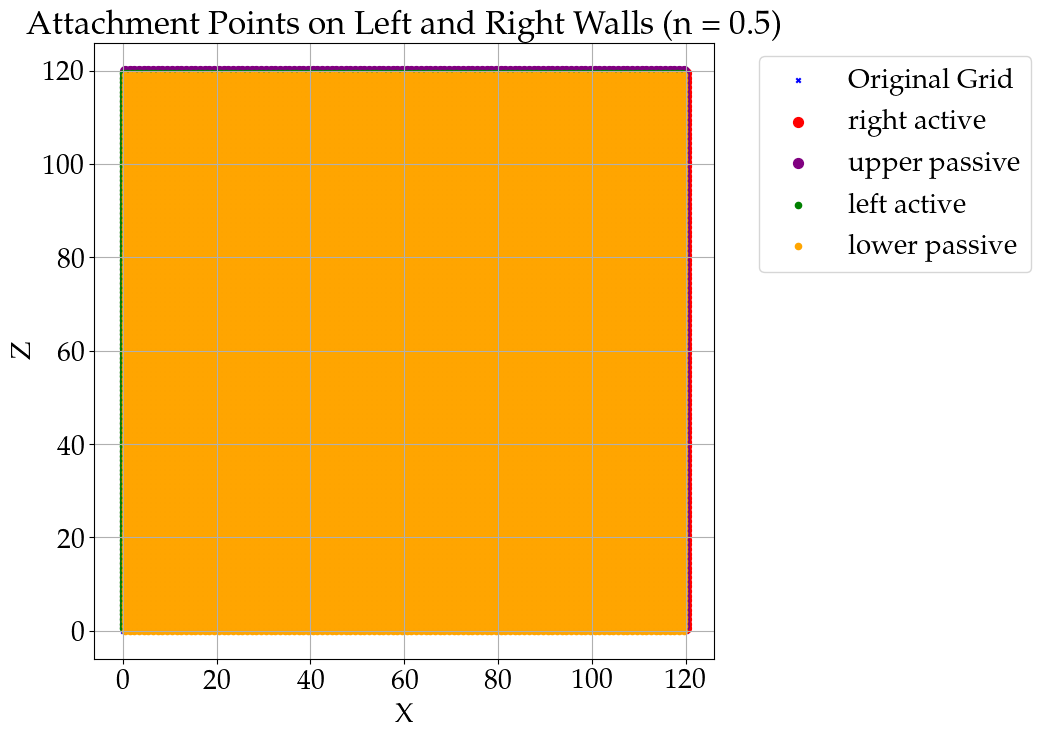

In [33]:
# Get the attachment points on the left and right walls
attachment_right, attachment_left = interpolate_active(xy_grid, par['n'])
attachment_top, attachment_bottom = interpolate_passive(xy_grid, par['n'])
# Plot a small fraction of the entire grid (for example, the top-left 20x20 section)
fig, ax = plt.subplots(figsize=(8, 8))
# Plot original grid points (blue)
ax.scatter(xy_grid[0, :, :], xy_grid[1, :, :], color='blue', marker= 'x',label='Original Grid', s=10)
# Plot attachment points on the right wall (red)
ax.scatter(attachment_right[0, :, :], attachment_right[1, :, :], color='red', label='right active', s=50)
ax.scatter(attachment_top[0, :, :], attachment_top[1, :, :], marker = 'o',color='purple', label='upper passive', s=50)
# Plot attachment points on the left wall (green)
ax.scatter(attachment_left[0, :, :], attachment_left[1, :, :], color='green', label='left active', s=20)
ax.scatter(attachment_bottom[0, :, :], attachment_bottom[1, :, :], marker = 'o',color='orange', label='lower passive', s=20)
# Set labels and title
ax.set_title(f"Attachment Points on Left and Right Walls (n = {par['n']})")
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
# Show plot
plt.show()


(2, 121, 121) (2, 121, 121) (2, 121, 121)


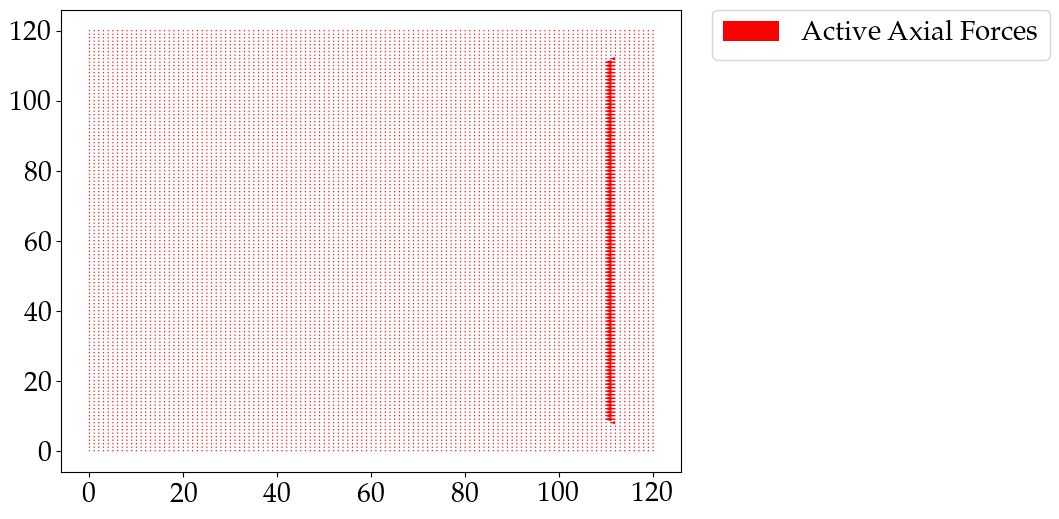

In [34]:
# Run the force field calculation
force_struct = force_field_struct(xy_grid, par)*5
force_active = force_field_active(xy_grid, T_grid, par)*50
force_passive = force_field_passive(xy_grid, par)*200

# Plot the force field using a quiver plot
plt.figure(figsize=(8, 6))
# plt.quiver(xy_grid[0, :, :], xy_grid[1, :, :], force_struct[0,:,:], force_struct[1,:,:], scale=10, color='blue', angles='xy', scale_units='xy',label = 'Structural Forces')
plt.quiver(xy_grid[0, :, :], xy_grid[1, :, :], force_active[0, :, :], force_active[1, :, :], scale=10, color='red', angles='xy', scale_units='xy',label = 'Active Axial Forces')
# plt.quiver(xy_grid[0, :, :], xy_grid[1, :, :], force_passive[0, :, :], force_passive[1, :, :], scale=10, color='green', angles='xy', scale_units='xy',label = 'Passive Axial Forces')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
print(force_active.shape,force_passive.shape,force_struct.shape)

## Test AP

In [35]:
def define_AP(**kwargs_sys):
    # disc_x, disc_y = kwargs_sys['size'], kwargs_sys['size']
    dx, dy = kwargs_sys['spacing'], kwargs_sys['spacing']
    N_sys = kwargs_sys['N_sys']
    # padding = kwargs_sys['padding']

    # def d_dx(f):
    #     return jnp.concatenate((jnp.zeros(
    #         (1, disc_x)), f[1:] - f[:-1], jnp.zeros((1, disc_x))),
    #                         axis=0)

    # def d_dy(f):
    #     return jnp.concatenate((jnp.zeros(
    #         (disc_y, 1)), f[:, 1:] - f[:, :-1], jnp.zeros((disc_y, 1))),
    #                         axis=1)

    def gen_params():
        return kwargs_sys['params_true'], {}, {}
    
    def gen_y0():
        print(kwargs_sys['u0'].shape)   
        return {'u':kwargs_sys['u0'],'v':kwargs_sys['v0'],'T':kwargs_sys['T0']}
    
    kernel = np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (dx * dy * 6)
    
    @jit
    def laplace(f):  #laplace of scalar
        f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
        f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
        return convolve2d(f_ext, kernel, mode='valid')
    @jit
    def epsilon(u,v,rp):
        return rp['eps0']+rp['mu1']*v/(u+rp['mu2'])
    @jit
    def epsilon_T(u):
        return 1 - 0.9*jnp.exp(-jnp.exp(-30*(jnp.abs(u) - 0.1)))
    @jit
    def eom(y, t, params, iparams, exparams):
            p=params
            u=y['u']
            v=y['v']
            T=y['T']
            dudt = p['D']*laplace(u)-(p['k'])*u*(u-p['a'])*(u-1) - u*v
            dvdt = epsilon(u,v,p)*(-v-(p['k'])*u*(u-p['a']-1))
            dTdt = epsilon_T(u)*(p['k_T']*jnp.abs(u)-T)
            return {'u':dudt, 'v':dvdt, 'T':dTdt}
    @jit
    def loss(ys, params, iparams, exparams, targets):
        u = ys['u']
        u_target = targets['u']
        return jnp.nanmean((u - u_target)**2)  
            
    return eom, loss, gen_params, gen_y0, {}

In [36]:
"""
    Reads in necessary parameters from config.ini
"""
N,size,params = read_config(['D','a','k','epsilon_0','mu_1','mu_2','k_T','delta_t_e'],mode = 'chaos')
keys = ['D','a','k','eps0','mu1','mu2','k_T']
tol = 1
params_true = dict(zip(keys,params[:-1]))
params_low = {key: value - value*tol for key, value in params_true.items()}
params_high = {key: value + value*tol for key, value in params_true.items()}

In [37]:
delta_t_e = 0.08
sampling_rate = 10
length = 30
t_evals = np.linspace(0, delta_t_e*sampling_rate*length, length)
u_fit = u[:length*sampling_rate][::sampling_rate,:,:]
T_fit = T[:length*sampling_rate][::sampling_rate,:,:]
v_fit = v[:length*sampling_rate][::sampling_rate,:,:]
u0 = u_fit[0]
v0 = v_fit[0]
T0 = T_fit[0]
u_fit.shape

(30, 100, 100)

In [38]:
targets = {'u':u_fit.reshape(1,length,100,100),'v':v_fit.reshape(1,length,100,100),'T':T_fit.reshape(1,length,100,100)}
kwargs_sys = {'size': 100,
              'spacing': 1,
              'N_sys': 1,
              'params_true': params_true,
              'u0': u0,'v0': v0,'T0': T0}
kwargs_adoptODE = {'epochs': 10,'N_backups': 1,'lr': 1e-3,'lower_b': params_low,'upper_b': params_high,
                   'lower_b_y0':{'u':u0,'v':v0,'T':T0},
                    'upper_b_y0':{'u':u0,'v':v0,'T':T0},}

In [39]:
# Setting up a dataset via simulation
Simulation_AP = simple_simulation(define_AP,
                            t_evals,
                            kwargs_sys,
                            kwargs_adoptODE)

(100, 100)


In [40]:
dataset_AP = dataset_adoptODE(define_AP,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE,
                                true_params=params_true)
_ = train_adoptODE(dataset_AP)                  
print('Found params: ', dataset_AP.params_train)

Epoch 000:  Loss: 7.9e-03,  Params Err.: 0.0e+00, y0 error: nan, Params Norm: 8.6e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 001:  Loss: 7.7e-03,  Params Err.: 2.4e-03, y0 error: nan, Params Norm: 8.6e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 002:  Loss: 7.0e-03,  Params Err.: 3.9e-03, y0 error: nan, Params Norm: 8.6e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 003:  Loss: 6.3e-03,  Params Err.: 5.3e-03, y0 error: nan, Params Norm: 8.6e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 004:  Loss: 6.0e-03,  Params Err.: 6.9e-03, y0 error: nan, Params Norm: 8.6e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 005:  Loss: 5.5e-03,  Params Err.: 8.7e-03, y0 error: nan, Params Norm: 8.5e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 006:  Loss: 4.9e-03,  Params Err.: 1.0e-02, y0 error: nan, Params Norm: 8.5e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 007:  Loss: 4.6e-03,  Params Err.: 1.2e-02, y0 error: na

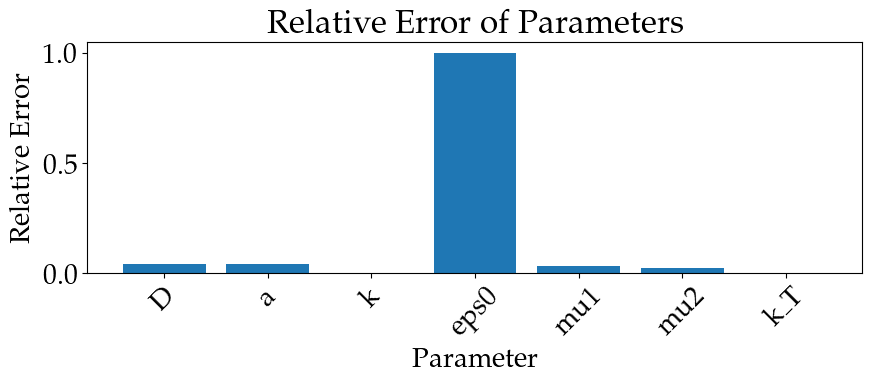

In [41]:
# Get the parameter names
param_names = list(params_true.keys())

# Calculate the relative error for each parameter
relative_errors = []
for param_name in param_names:
    real_value = params_true.get(param_name, np.nan)
    train_value = dataset_AP.params_train.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)

# Plot the relative errors
plt.figure(figsize=(10, 3))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()

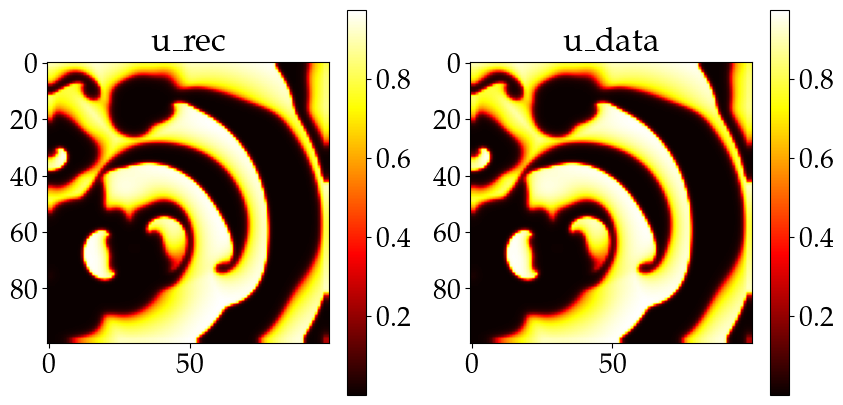

In [42]:
#plot two heatmaps next to each other. 
fig, ax = plt.subplots(1,2,figsize=(10,5))
im = ax[0].imshow(dataset_AP.ys['u'][0,20,:,:], cmap='hot')
ax[0].set_title('u_rec')
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(u_fit[20], cmap='hot')
ax[1].set_title('u_data')
fig.colorbar(im, ax=ax[1])
plt.show()

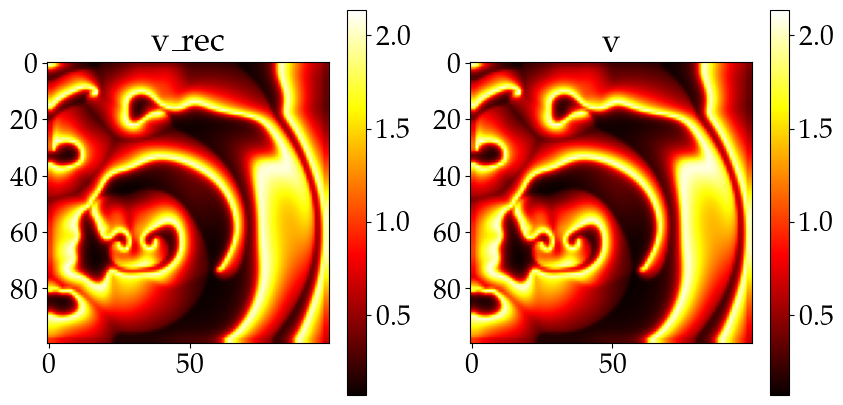

In [43]:
#plot two heatmaps next to each other. 
fig, ax = plt.subplots(1,2,figsize=(10,5))
im = ax[0].imshow(Simulation_AP.ys['v'][0,1,:,:], cmap='hot')
ax[0].set_title('v_rec')
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(v_fit[1], cmap='hot')
ax[1].set_title('v')
fig.colorbar(im, ax=ax[1])
plt.show()